<a href="https://colab.research.google.com/github/jgak12/WormTrackV2/blob/main/WormTrackerV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

WORM TRACKER

TO DO:

* pull small format images from large images based on difference tracked location (done)
* Find a way to relabel all images in the img file so they can be marked which have worms and which dont (kindof done?)
* If time, write quick file relabeling program that gives all files numbered sequence (done
* Write function that turns video into series of .jpg with ordered filenames
* Make user-interface to select intitial worm positions/#worms
* UI to select desired outputs
* UI to select type of experiment


In [1]:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook. Use your UPR account 

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def loadFromDrive(file_id, local_name):
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(local_name)
  
#from google.colab import drive
#drive.mount('/content/drive')

Read Data


# New Section

In [2]:
#Import everything

import glob, os 
from skimage import io, transform
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import Sequential ##Might change this to Convolutional
from keras.layers import Activation, Dropout, Flatten, Dense
#from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Convolution3D
from keras.layers.convolutional import Conv2D
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, classification_report
plt.rcParams['axes.grid']=False
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'viridis'

import matplotlib.pyplot as plt
import numpy as np

import HelpFxns


In [3]:


# img1= plt.imread('/content/drive/MyDrive/WormTracker/WormImgs/wormImgLowQ_0001.jpg')
# img2= plt.imread('/content/drive/MyDrive/WormTracker/WormImgs/wormImgLowQ_0002.jpg')

def frame_compare(img1,img2,showImg=False):
  #plt.imshow(img1)
  #plt.imshow(img2)
  #sum=img2-img1
  sum= np.zeros(img2.shape)

  rowLen=sum.shape[0]
  colLen=sum.shape[1]

  for pixelx in range(0,colLen):
    for pixely in range(0,rowLen): #here
      for pixelrgb in range(0,3):
        if img2[pixely,pixelx,pixelrgb] >= img1[pixely,pixelx,pixelrgb]:
          sum[pixely,pixelx,pixelrgb]= img2[pixely,pixelx,pixelrgb]-img1[pixely,pixelx,pixelrgb]
        else:
          sum[pixely,pixelx,pixelrgb]= img1[pixely,pixelx,pixelrgb]-img2[pixely,pixelx,pixelrgb]

  ##print(img1[1:5,1:5])
  #print(img2[1:5,1:5])
  #print(sum[1:5,1:5])

  #print(sum.shape[0])


  dif_sens=40 #remove later
  dif_sense= 10

  motion_sensitivity=1.1 * 10

  xavg=0
  yavg=0


  #for xx in range(0, sum.shape[1]):
  # for yy in range(0, sum.shape[0]):
  #   for zz in range(0, sum.shape[2]):
  #     if sum[yy, xx, zz]<= dif_sens:
  #        sum[yy,xx,zz]=0


  #print(sum[0:10, 0:10])

  difArray= np.zeros((sum.shape[0],sum.shape[1]))
  #print(difArray.shape)
  totPixelDif=0;
  numNonZpixels=0
  for pixelx in range(0,colLen):
    for pixely in range(0,rowLen):
      for pixelrgb in range(0,3):
        chanPixelDif= sum[pixely,pixelx,pixelrgb]
        totPixelDif = totPixelDif + chanPixelDif
      if totPixelDif > dif_sense*3:
        #print('hi')
        difArray[pixely,pixelx]=totPixelDif
      totPixelDif=0

  #print(difArray)
  difArray[:,:]= difArray[:,:]/3
  #print(difArray)

  #print(difArray)
  weightTot=0
  for pixelx in range(0,colLen):
    for pixely in range(0,rowLen):
      xavg=xavg + (difArray[pixely,pixelx]*pixelx)
      yavg=yavg + (difArray[pixely,pixelx]*pixely)

      weightTot= weightTot + difArray[pixely,pixelx]

  if xavg>motion_sensitivity:
    xavg=round(xavg/weightTot)
    yavg=round(yavg/weightTot)
    pos=[xavg, yavg]
  else: #returns 00 if change below threshold
    xavg=1
    yavg=1
    pos=[xavg, yavg]

  size=3

  #imshow
  #print(difArray)
  if showImg==True:
    plt.subplot(2,2,1)
    plt.imshow(sum)
    plt.subplot(2,2,2)
    plt.imshow(difArray)
    plt.subplot(2,2,3)
    difArrayMarked= difArray
    #difArrayMarked[round(yavg-size):round(yavg+size), round(xavg-size):round(xavg+size)]= 1000000
    plt.imshow(difArrayMarked)
    print(xavg,yavg)
    plt.scatter(xavg,yavg)
    plt.subplot(2,2,4)
    plt.imshow(img2)

  plt.subplot(1,1,1)
  plt.imshow(img2)
  plt.scatter(xavg,yavg)

  return pos


In [4]:
def numToIndex(n,numDigits):
  out=''
  num=str(n)
  for i in range(0,numDigits-len(num)):
    out= out+'0'
  out= out+ num
  return out

def sort_rename(path,):
  #Takes in a path to a file of numbered, sequential images
  #renames all the files in the directory with '_*' sequential number from 1:n added

  ldseg = glob.glob(os.path.join(path, '*.jpg')) #pulls list of all files in folder
  print('Dataset contains {} images'.format(len(ldseg))) #returns how many images in list
  listlen= len(ldseg)

  print(ldseg) #For some reason, glob pulls the files in a wrong order
  ldseg.sort() #this sorts them alphabetically ASSUMES IMAGES ARE NUMBERED ALREADY/PROPERLY
  print(ldseg)

  i=1
  for filename in ldseg:
    dst =  filename.split('_')[0] + '_' + numToIndex(i,4) + '.jpg' #removes original index marker after a "_"
    print(dst)
    print(filename)
    src =filename
    print(src)
    print(dst)
    os.rename(src, dst)
    i += 1

#sort_rename(path)

In [5]:
#video to imgs
def vidToImgs(path, outputpath):
  video= cv2.VideoCapture(path)
  success=True
  count=1
  while success:
    success, image = video.read()
    cv2.imwrite(outputpath+ 'VideoFrame_{0}.jpg'.format(numToIndex(count,6)), image)
    count+=1
    print("Saved Image" + str(count))

#vidToImgs('/content/drive/MyDrive/WormTracker/wormVid/temp-04222022134339-0000.avi','/content/drive/MyDrive/WormTracker/VidOutput/')

In [6]:
def dataset(file_list, size=(400,512), flattened=False): #,size=(300,180)
	data = []
	for i, file in enumerate(file_list):
		image = io.imread(file)
		#image = transform.resize(image, size, mode='constant')
		if flattened:
			image = image.flatten()

		data.append(image)

	labels = [1 if f.split("/")[-1][0] == 'W' else 0 for f in file_list]


	return np.array(data), np.array(labels)
 
def ImgArray(file_list):
	outputArray=[]
	for i, file in enumerate(file_list):
		image = io.imread(file)
		outputArray.append(image)
	return np.array(outputArray)
 
 
def folderToImgArray(ImgPath):
	imlist = glob.glob(os.path.join(ImgPath, '*.jpg'))
	imlist.sort()
	output= ImgArray(imlist)
	return output



In [ ]:
# #loading list of images
# #path="/content/drive/MyDrive/WormTracker/LabeledImgs/" #path to image folder
# path="/content/drive/MyDrive/WormTracker/WormImgs/"
# imlist = glob.glob(os.path.join(path, '*.jpg')) #pulls list of all files in folder
# print('Dataset contains {} images'.format(len(imlist))) #returns how many images in list
# listlen= len(imlist)

# print(imlist) #For some reason, glob pulls the files in a wrong order
# imlist.sort() #this sorts them alphabetically ASSUMES IMAGES ARE NUMBERED ALREADY/PROPERLY
# print(imlist)

# # Load the data. The same as pollen dataset read-skimage (May take a few seconds)
# #data,labels = dataset(imlist) 
# data,labels= dataset(imlist)
# data= np.array(data)
# print(labels)
# #this loads the images as a numpy ndarray with each image represented as matrix of pixel values

In [9]:
## This block gets the list of x,y positions for each frame

def getPosList(imgArray, stepSize='1'):
  stepSize=5
  #poslist= np.zeros((listlen-1, 2)) #x,y
  poslist= np.empty((0,2), int)


  for i in range(0,listlen-1,stepSize):
    img1=imgArray[i,:,:,:]
    img2=imgArray[i+1,:,:,:]

    #frame_compare
    pos=frame_compare(img1,img2)
    #print(pos)
    
    poslist= np.append(poslist,np.array([pos]),axis=0)
    #All i want to do is add new paired x and y values to a new row... how is this
    #so much to ask



  return poslist

#poslist= getPosList(data,5)

In [10]:

# plt.scatter(poslist[:,0],poslist[:,1] )
# plt.gca().invert_yaxis()
# plt.xlim([0, 512])
# plt.ylim([0,400])

In [11]:
def pullSub(inImg, pos, outputSize):
  if outputSize[0]>inImg.shape[0] or outputSize[1]>inImg.shape[1]:
    return "output bigger than image"
  xmin=int(pos[0]-(outputSize[0]/2))
  xmax=int(pos[0]+(outputSize[0]/2))
  ymin=int(pos[1]-(outputSize[1]/2))
  ymax=int(pos[1]+(outputSize[1]/2))
  if xmin<0:
    xmin=0
  if xmax>(inImg.shape[1]):
    xmax=(inImg.shape[1]-1)
  if ymin<0:
    ymin=0
  if ymax>(inImg.shape[0]):
    ymax=(inImg.shape[0]-1)

  subImg=inImg[ymin:ymax, xmin:xmax]

  return subImg




END OF HELPER FXNS

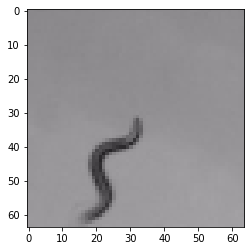

In [13]:
a= pullSub(img2, pos1, [64,64])
plt.imshow(a)

In [ ]:
# #JUST A LITTLE TEST BLOCK
# ldseg = glob.glob(os.path.join(path, '*.jpg')) #pulls list of all files in folder
# print('Dataset contains {} images'.format(len(ldseg))) #returns how many images in list
# listlen= len(ldseg)

# print(ldseg) #For some reason, glob pulls the files in a wrong order
# ldseg.sort() #this sorts them alphabetically ASSUMES IMAGES ARE NUMBERED ALREADY/PROPERLY
# print(ldseg)

In [15]:
#Display images in series that show tracking
import time
def displayTrack(pathToImages, stepSize=5):
  imgPath=pathToImages
  imgArray= folderToImgArray(imgPath)
  listlen=imgArray.shape[0]
  print(listlen)

  #poslist= np.zeros((listlen-1, 2)) #x,y
  poslist= np.empty((0,2), int)


  for i in range(0,listlen-1,stepSize):
    img1=imgArray[i,:,:,:]
    img2=imgArray[i+1,:,:,:]

    #frame_compare
    pos=frame_compare(img1,img2)
    #print(pos)
    plt.close()
    poslist= np.append(poslist,np.array([pos]),axis=0)
  print(poslist.shape)

  for i in range(0,poslist.shape[0]):
    plt.imshow(imgArray[i*stepSize])
    plt.scatter(poslist[i,0],poslist[i,1])
    time.sleep(.5)
    plt.close()

displayTrack('D:\WormTrack\WormData\wormimgs_lowqual\\')

38
(8, 2)


In [25]:
imgArray= folderToImgArray('/content/drive/MyDrive/WormTracker/WormImgs/')

# for i in range(0,5):
#   plt.figure()
#   plt.imshow(imgArray[i,:,:,:])
#   time.sleep()

import numpy as np
import cv2
import os
 
width = 1280
height = 720
channel = 3
 
fps = 10
sec = 3
 
# Syntax: VideoWriter_fourcc(c1, c2, c3, c4) # Concatenates 4 chars to a fourcc code
#  cv2.VideoWriter_fourcc('M','J','P','G') or cv2.VideoWriter_fourcc(*'MJPG)
 
fourcc = cv2.VideoWriter_fourcc(*'MP4v') # FourCC is a 4-byte code used to specify the video codec.
# A video codec is software or hardware that compresses and decompresses digital video. 
# In the context of video compression, codec is a portmanteau of encoder and decoder, 
# while a device that only compresses is typically called an encoder, and one that only 
# decompresses is a decoder. Source - Wikipedia
 
#Syntax: cv2.VideoWriter( filename, fourcc, fps, frameSize )
video = cv2.VideoWriter('test.mp4', fourcc, float(fps), (width, height))
 
for frame_count in range(fps*sec):
    img = imgArray[frame_count]
    video.write(img)
 
video.release()

Label all these images


In [ ]:
#This block of code is so sick and took me ages- J
#Use this block to auto-generate annotated images to use for training
#Give an input path containing a series of sequential worm images
#It will track the worm with motion sensing, guess where it is
#Based on that guess, it will save an image containing the worm, labeled with a W
#Then grab a random image from another portion of the original, that will not contain a worm, labeled N

import cv2
import random

def labeledSubImg(imgA,imgB,imgDim):
  motionPos= frame_compare(imgA, imgB)

  motionImg= pullSub(imgB,motionPos,imgDim)

  randx= random.randrange(0+imgDim[1],imgB.shape[1]-imgDim[1])
  randy= random.randrange(0+imgDim[0],imgB.shape[0]-imgDim[0])
  count=0
  while (randx>(motionPos[0]-round(imgDim[1]/2)) and randx<(motionPos[0]+round(imgDim[1]/2))) and (randy>(motionPos[1]-round(imgDim[0]/2)) and randy<(motionPos[1]+round(imgDim[0]/2))):
    randx= random.randrange(0+imgDim[1],imgB.shape[1]-imgDim[1])
    randy= random.randrange(0+imgDim[0],imgB.shape[0]-imgDim[0])
    count+= 1
    if count >30:
      randx= 0+imgDim[1]
      randy= 0+imgDim[0]
      print('randomization took too long')
      break
  nonMotionImg= pullSub(imgB,[randx,randy],imgDim)
  plt.subplot(1,2,1)
  plt.imshow(motionImg)
  plt.subplot(1,2,2)
  plt.imshow(nonMotionImg)
  print(motionPos)
  print(randx,randy)
  return motionImg, nonMotionImg
  
    

def makeClassifierImages(imgPath, outputPath, imgDimensions, indexStart=0):
  #ImgDimensions in a Rows,Columns notation
  #pos as X,Y notation
  path=imgPath
  imgDimensions= list(imgDimensions)
  imgList= glob.glob(os.path.join(path, '*.jpg'))
  listLen= len(imgList)
  imgList.sort()

  for i in range(0,listLen-1):
    imgA= io.imread(imgList[i])
    imgB= io.imread(imgList[i+1])
  #imgA= io.imread(imgList[1])
  #imgB= io.imread(imgList[2])
    subImg,nonMotionImg= labeledSubImg(imgA,imgB,imgDimensions)
    
    cv2.imwrite(outputPath+ '{0}imgLabeled_{1}.jpg'.format("W",(numToIndex(i+indexStart,4))), subImg)
    cv2.imwrite(outputPath+ '{0}imgLabeled_{1}.jpg'.format("N",(numToIndex(i+indexStart,4))), nonMotionImg)



#makeClassifierImages('/content/drive/MyDrive/WormTracker/WormImgs/','/content/drive/MyDrive/WormTracker/LabeledImgs/', [64,64])


NOW THE NEURAL NETWORK:


In [ ]:
dataPath = '/content/drive/My Drive/WormTracker/LabeledImgs/'
imgsList= glob.glob(os.path.join(dataPath, '*.jpg')) #pulls list of all files in folder
listlen= len(imgsList)
imgsList.sort() #this sorts them alphabetically ASSUMES IMAGES ARE NUMBERED ALREADY/PROPERLY
print(imgsList)
trainData,labels= dataset(imgsList, (64,64)) #trainData is now an array of images, labels is an array of label values 0/1
print(labels)
print(trainData.shape)
# Create a training and testing dataset with 25% of the samples
X_train, X_test, y_train, y_test = train_test_split(trainData,labels, test_size=.25,random_state=0,)
#ids=np.array(range(data.shape[0]))
#X_train, X_ids, y_train, y_ids = train_test_split(data,ids, test_size=.25,random_state=0,)
#X_test=labels[X_ids]; y_test=labels[y_ids]
print('Done')


In [ ]:
# check shape of the input image to fit with the network 
print(X_train.shape)
print(X_test.shape)

In [ ]:
import skimage
#These were original values, I reduced to 64x64 because we already took down to that size
X_train_resized = np.asarray([skimage.transform.resize(image, (224,224)) for image in X_train])
X_test_resized = np.asarray([skimage.transform.resize(image, (224,224)) for image in X_test])

#X_train_resized = np.asarray([skimage.transform.resize(image, (64,64)) for image in X_train])
#X_test_resized = np.asarray([skimage.transform.resize(image, (64,64)) for image in X_test])

print(X_train_resized.shape)
print(X_test_resized.shape)
# plt.subplot(1,2,1)
# plt.imshow(X_train[2,:,:,:])
# plt.subplot(1,2,2)
# plt.imshow(X_train_resized[2,:,:,:])


In [ ]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

y_train_encoded.shape

In [ ]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import time
import os


train_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
                horizontal_flip=True,
                samplewise_center=True,
                width_shift_range=.2,
                height_shift_range=.2,                
                samplewise_std_normalization=True).flow(X_train_resized, y_train_encoded)
#val_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
#                samplewise_center=True,                
#                samplewise_std_normalization=True).flow(xValid, yValid, shuffle=False)        
test_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
                samplewise_center=True,                
                samplewise_std_normalization=True).flow(X_test_resized, y_test_encoded, shuffle=False)

In [ ]:
Top=False
weights=None
layer_cut=-6
lr_rate=.001
rand_seed=128
epochs=25
mobile = tf.keras.applications.mobilenet.MobileNet( include_top=Top,
                                                           input_shape=(224,224,3),
                                                           pooling='avg', weights='imagenet',
                                                          )  #was 224,224,3
                 
x=mobile.layers[layer_cut].output
x = Flatten()(x)
x=Dense(128, kernel_regularizer = regularizers.l2(l = 0.015), activation='relu')(x)

x=Dropout(rate=.5, seed=rand_seed)(x)
predictions=Dense (2, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=predictions)
        
for layer in model.layers:
    layer.trainable=True
model.compile(Adam(lr=lr_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Trying to figure out what the purpose of changing x is
#I get that he's manipulating each layer, but is the memory of each operation stored in x?
#are the predictions: layer[-6] -> flattened ->dense -> dropout -> dense
#I'm going to assume thats the case, I just dont know how else layers are added to a model

print(mobile.layers)
x=mobile.layers[layer_cut].output
print(mobile.layers[-6].output)
x = Flatten()(x)
print(x)
x=Dense(128, kernel_regularizer = regularizers.l2(l = 0.015), activation='relu')(x)
print(x)

In [ ]:
x,y  = train_gen.next()

In [ ]:
# set ansi color values
Cblu ='\33[34m'
Cend='\33[0m'   # sets color back to default 
Cred='\033[91m'
Cblk='\33[39m'
Cgreen='\33[32m'
Cyellow='\33[33m'

In [ ]:
start_epoch=0
start=time.time()
results = model.fit_generator(generator = train_gen, validation_data= test_gen, epochs=epochs, initial_epoch=start_epoch, verbose=1)
stop=time.time()
duration = stop-start
hrs=int(duration/3600)
mins=int((duration-hrs*3600)/60)
secs= duration-hrs*3600-mins*60
msg='{0}Training took\n {1} hours {2} minutes and {3:6.2f} seconds {4}'
print(msg.format(Cblu,hrs, mins,secs,Cend))
tacc=results.history['accuracy']
tloss=results.history['loss']
vacc=results.history['val_accuracy']
vloss=results.history['val_loss']

In [ ]:
Epoch_count=len(tloss)
Epochs=[]
for i in range (0,Epoch_count):
    Epochs.append(i+1)
index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
val_lowest=vloss[index_loss]
index_acc=np.argmax(vacc)
val_highest=vacc[index_acc]
plt.style.use('fivethirtyeight')
sc_label='best epoch= '+ str(index_loss+1)
vc_label='best epoch= '+ str(index_acc + 1)
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axes[0].plot(Epochs,tloss, 'r', label='Training loss')
axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
axes[0].scatter(index_loss+1,val_lowest, s=150, c= 'blue', label=sc_label)
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
axes[1].scatter(index_acc+1,val_highest, s=150, c= 'blue', label=vc_label)
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout
#plt.style.use('fivethirtyeight')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cf=confusion_matrix(y_test, preds, labels=[0,1])

import pandas as pd
df=pd.DataFrame(cf,columns=['pred NP','pred P'],index=['true NP','true P'])
df

In [ ]:
idx=100;
#pred=model.predict(X_test[[idx],...])
plt.imshow(X_test[idx])
plt.grid(False)
plt.title("Score {:.3f} / Truth {}".format(preds[idx][1], y_test[idx]) )

In [ ]:
# contact sheet
visualize(X_test,y_test,decisions,rawscores,sortids)